In [31]:
import os
from IPython.display import clear_output

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from torchvision import transforms

%matplotlib inline

Загрузим csv файл

In [2]:
!unzip /data/kaggle-iwildcam-2019/train.csv.zip -d /data/kaggle-iwildcam-2019/

Archive:  /data/kaggle-iwildcam-2019/train.csv.zip
replace /data/kaggle-iwildcam-2019/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
with open('/data/kaggle-iwildcam-2019/train.csv') as data_file:
    train_df_all = pd.read_csv(data_file)

In [3]:
train_df_all.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


Разархивируем тестовые картинки. В папку /data/kaggle-iwildcam-2019/train-images/, почему-то, картинки не помещались до конца, поэтому грузим все в папку /data/

!unzip /data/kaggle-iwildcam-2019/train_images.zip -d /data/kaggle-iwildcam-2019/train-images/
print("ready")

!unzip /data/kaggle-iwildcam-2019/train_images.zip -d /data/
print("ready")

Ячейка выше помечена, как текст, потому что на гитхабе список файлов отображается целиком, а не с прокруткой. А список ооочень длинный

Разархивируем тестовые картинки

In [94]:
!unzip /data/kaggle-iwildcam-2019/test_images.zip -d /data/kaggle-iwildcam-2019/test-images/
print("ready")

Archive:  /data/kaggle-iwildcam-2019/test_images.zip
replace /data/kaggle-iwildcam-2019/test-images/22234467-2bfb-11e9-bcad-06f10d5896c4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
ready


In [4]:
batch_size = 64
img_size = 64

TRAIN_IMGS_DIR = '/data/'
TEST_IMGS_DIR = '/data/kaggle-iwildcam-2019/test_images/'

In [5]:
num_classes = len(train_df_all['category_id'].unique())
num_classes

14

In [6]:
train_df_all['category_id'].unique()

array([19,  0,  3,  8,  4, 13,  1, 11, 16, 17, 14, 18, 10, 22])

Видим, что классы не принимают значения от 0 до 13. Перекодируем классы

In [10]:
category = train_df_all['category_id'].unique()

encoder = dict([(v, k) for v, k in zip(category, range(len(category)))])
decoder = dict([(v, k) for k, v in encoder.items()])

print(pd.DataFrame({'Initial classes': list(encoder.keys()),
                    'Encoded classes': list(encoder.values())}).to_string(index=False))

Encoded classes  Initial classes
              1                0
              6                1
              2                3
              4                4
              3                8
             12               10
              7               11
              5               13
             10               14
              8               16
              9               17
             11               18
              0               19
             13               22


In [11]:
def encoding(labels):
        return encoder[int(labels)]

In [12]:
train_df_all['category_id'] = train_df_all['category_id'].apply(encoding)

Нас интересуют колонки "file name" и "category_id"

In [13]:
train_df, test_df = train_test_split(train_df_all[['file_name', "category_id"]],
                                     test_size = 0.2,                                     
                                     shuffle = True
                                    )

Напишем наш класс Dataset

In [27]:
class IWildDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.train_labels = self.df['category_id']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                               self.df.iloc[idx, 0])
        image = cv2.imread(img_name)
        if image is not None:
            label = self.df.iloc[idx, 1]
            if self.transforms is not None:
                image = self.transforms(image)
            return image, label
        else:
            print("not found") # это было нужно для отслеживания не распоковавшихся трейновых картинок
            print(img_name)

In [15]:
aug = transforms.Compose([transforms.ToPILImage(),                          
                          transforms.Resize((img_size, img_size)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

In [16]:
dataset_train = IWildDataset(df=train_df, # разархивировалось не все, берем, что есть
                             img_dir=TRAIN_IMGS_DIR,
                             transforms=aug)

dataset_test = IWildDataset(df=test_df,
                            img_dir=TRAIN_IMGS_DIR,
                            transforms=aug)

In [17]:
train_loader = DataLoader(dataset=dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)

Наш стандартный код для тренировки

In [28]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        print("batch_num {}".format(batch_num))
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        
        output = model(data)
        pred = torch.max(output, 1)[1]

        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(dataset_train) / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   

Мега простая сеть. Для DL здесь будет что-нибудь нормальное

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.body = nn.Sequential(nn.Conv2d(3,8,5), nn.ReLU(), nn.MaxPool2d(2,2),\
                               nn.Conv2d(8,16,5), nn.ReLU(), nn.MaxPool2d(2,2))
        
        self.classifier = nn.Linear(2704, num_classes)
        
    def forward(self, x):
        out = self.body(x)
        out = self.classifier(out.flatten(start_dim=1))
        
        return(F.log_softmax(out, dim = -1))
        
model = ConvNet()

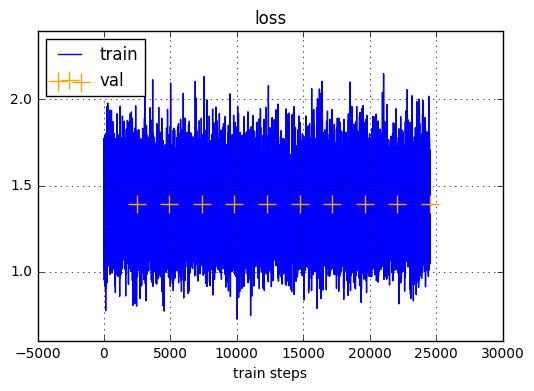

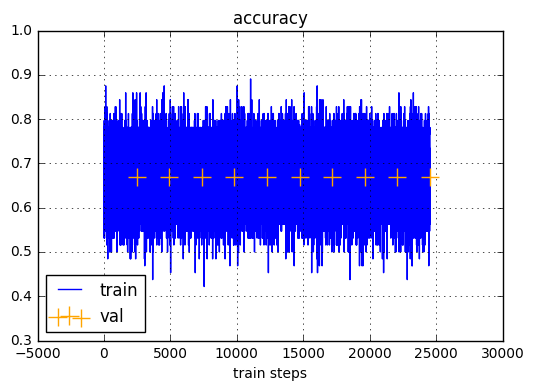

In [43]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, opt, 10)